In [1]:
import pandas as pd
import numpy as np
import glob
import os

all_data = []
for i in range(1, 39):
    file_path = f'data/time_series/current_{i}.csv'
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df_clean = df.dropna()
        if not df_clean.empty:
            all_data.append(df_clean)

combined_data = pd.concat(all_data, ignore_index=True)
print(f"Общее количество записей после очистки: {len(combined_data)}")
print(f"Исходное количество файлов: {len(all_data)}")


Общее количество записей после очистки: 84507036
Исходное количество файлов: 29


In [2]:
from scipy import stats

stats_dict = {}
for column in combined_data.columns:
    data_col = combined_data[column]
    stats_dict[column] = {
        'count': len(data_col),
        'mean': data_col.mean(),
        'std': data_col.std(),
        'min': data_col.min(),
        'max': data_col.max(),
        'median': data_col.median(),
        'q25': data_col.quantile(0.25),
        'q75': data_col.quantile(0.75),
        'variance': data_col.var(),
        'skewness': stats.skew(data_col),
        'kurtosis': stats.kurtosis(data_col),
        'range': data_col.max() - data_col.min(),
        'iqr': data_col.quantile(0.75) - data_col.quantile(0.25)
    }

stats_df = pd.DataFrame(stats_dict).T
display(stats_df)


,count,mean,std,min,max,median,q25,q75,variance,skewness,kurtosis,range,iqr
current_R,84507036.0,0.037652,2.419144,-5.371379,5.486113,0.044338,-2.333695,2.389458,5.852259,0.002111,-1.434247,10.857493,4.723153
current_S,84507036.0,-0.076015,2.407028,-5.477873,5.409724,-0.090395,-2.421489,2.266799,5.793785,0.009767,-1.429483,10.887597,4.688288
current_T,84507036.0,0.039181,1.888078,-4.308843,4.291877,0.050635,-1.804995,1.879836,3.564838,-0.006388,-1.435170,8.600720,3.684831


In [1]:
# Jupyter Notebook: data_comparison_analysis.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.fft import fft, fftfreq
import warnings
warnings.filterwarnings('ignore')

# Настройка стиля графиков
plt.style.use('default')
sns.set_palette("husl")

print("🔍 Статистическое сравнение данных двигателя")
print("=" * 50)

# Пути к файлам
file1 = "motor_data_20250813_131400.csv"  # WebSocket данные
file2 = "data/time_series/current_1.csv"  # Существующие данные

print(f"📁 Файл 1 (WebSocket): {file1}")
print(f"📁 Файл 2 (Существующий): {file2}")


🔍 Статистическое сравнение данных двигателя
📁 Файл 1 (WebSocket): motor_data_20250813_131400.csv
📁 Файл 2 (Существующий): data/time_series/current_1.csv


In [2]:
# Загрузка данных
try:
    print("📊 Загрузка данных...")
    
    # Загружаем первый файл
    df1 = pd.read_csv(file1)
    print(f"✅ {file1}: {len(df1):,} строк, {len(df1.columns)} колонок")
    print(f"   Колонки: {list(df1.columns)}")
    
    # Загружаем второй файл
    df2 = pd.read_csv(file2)
    print(f"✅ {file2}: {len(df2):,} строк, {len(df2.columns)} колонок")
    print(f"   Колонки: {list(df2.columns)}")
    
    # Проверяем структуру данных
    print(f"\n📋 Структура данных:")
    print(f"Файл 1 - первые 3 строки:")
    print(df1.head(3))
    print(f"\nФайл 2 - первые 3 строки:")
    print(df2.head(3))
    
except Exception as e:
    print(f"❌ Ошибка загрузки файлов: {e}")
    print("Проверьте пути к файлам и их существование")


📊 Загрузка данных...
✅ motor_data_20250813_131400.csv: 500,000 строк, 3 колонок
   Колонки: ['current_R', 'current_S', 'current_T']
✅ data/time_series/current_1.csv: 1,536,492 строк, 3 колонок
   Колонки: ['current_R', 'current_S', 'current_T']

📋 Структура данных:
Файл 1 - первые 3 строки:
   current_R  current_S  current_T
0   3.107400  -0.619670  -2.362766
1   2.399042  -0.519393  -2.540585
2   3.407693  -0.764189  -2.839404

Файл 2 - первые 3 строки:
   current_R  current_S  current_T
0   1.894377   0.949463  -2.165271
1   2.128889   0.926111  -2.309938
2   2.373001   0.882154  -2.526938


In [3]:
# Проверка и приведение к единому формату
print("🔄 Приведение данных к единому формату...")

# Убеждаемся, что у нас есть нужные колонки
required_columns = ['current_R', 'current_S', 'current_T']

for df_name, df in [("Файл 1", df1), ("Файл 2", df2)]:
    missing_cols = [col for col in required_columns if col not in df.columns]
    if missing_cols:
        print(f"⚠️  {df_name}: отсутствуют колонки {missing_cols}")
    else:
        print(f"✅ {df_name}: все необходимые колонки присутствуют")

# Берем только колонки токов для сравнения
df1_clean = df1[required_columns].copy()
df2_clean = df2[required_columns].copy()

# Ограничиваем размер для корректного сравнения
max_samples = min(len(df1_clean), len(df2_clean), 100000)  # максимум 100k для анализа
df1_sample = df1_clean.head(max_samples).copy()
df2_sample = df2_clean.head(max_samples).copy()

print(f"📏 Используем для анализа: {max_samples:,} образцов из каждого файла")
print(f"   Файл 1: {len(df1_sample):,} строк")
print(f"   Файл 2: {len(df2_sample):,} строк")


🔄 Приведение данных к единому формату...
✅ Файл 1: все необходимые колонки присутствуют
✅ Файл 2: все необходимые колонки присутствуют
📏 Используем для анализа: 100,000 образцов из каждого файла
   Файл 1: 100,000 строк
   Файл 2: 100,000 строк


In [4]:
# Описательная статистика
print("📊 ОПИСАТЕЛЬНАЯ СТАТИСТИКА")
print("=" * 40)

def describe_dataset(df, name):
    print(f"\n📈 {name}:")
    print("-" * 30)
    
    for phase in ['current_R', 'current_S', 'current_T']:
        values = df[phase].values
        print(f"  {phase}:")
        print(f"    Среднее:     {np.mean(values):>10.6f}")
        print(f"    Медиана:     {np.median(values):>10.6f}")
        print(f"    Std:         {np.std(values):>10.6f}")
        print(f"    Мин:         {np.min(values):>10.6f}")
        print(f"    Макс:        {np.max(values):>10.6f}")
        print(f"    RMS:         {np.sqrt(np.mean(values**2)):>10.6f}")
        print(f"    Размах:      {np.max(values) - np.min(values):>10.6f}")
        print(f"    Асимметрия:  {stats.skew(values):>10.6f}")
        print(f"    Эксцесс:     {stats.kurtosis(values):>10.6f}")

describe_dataset(df1_sample, "ФАЙЛ 1 (WebSocket)")
describe_dataset(df2_sample, "ФАЙЛ 2 (Существующий)")


📊 ОПИСАТЕЛЬНАЯ СТАТИСТИКА

📈 ФАЙЛ 1 (WebSocket):
------------------------------
  current_R:
    Среднее:      -0.014260
    Медиана:      -0.006621
    Std:           2.614900
    Мин:         -13.929652
    Макс:         13.777870
    RMS:           2.614939
    Размах:       27.707522
    Асимметрия:    0.010376
    Эксцесс:       2.190286
  current_S:
    Среднее:      -0.014642
    Медиана:      -0.008863
    Std:           2.636038
    Мин:         -14.430567
    Макс:         14.616105
    RMS:           2.636079
    Размах:       29.046672
    Асимметрия:    0.009302
    Эксцесс:       2.173078
  current_T:
    Среднее:       0.028976
    Медиана:       0.010665
    Std:           2.673135
    Мин:         -15.283165
    Макс:         15.337632
    RMS:           2.673292
    Размах:       30.620797
    Асимметрия:    0.032168
    Эксцесс:       2.304076

📈 ФАЙЛ 2 (Существующий):
------------------------------
  current_R:
    Среднее:       0.037859
    Медиана:       0.048453

In [5]:
# Сравнительный анализ разностей
print("\n🔍 СРАВНИТЕЛЬНЫЙ АНАЛИЗ")
print("=" * 40)

comparison_results = {}

for phase in ['current_R', 'current_S', 'current_T']:
    print(f"\n⚡ Фаза {phase}:")
    print("-" * 20)
    
    values1 = df1_sample[phase].values
    values2 = df2_sample[phase].values
    
    # Основные различия
    mean_diff = np.mean(values1) - np.mean(values2)
    std_diff = np.std(values1) - np.std(values2)
    rms_diff = np.sqrt(np.mean(values1**2)) - np.sqrt(np.mean(values2**2))
    
    print(f"  Разность средних: {mean_diff:>12.6f}")
    print(f"  Разность std:     {std_diff:>12.6f}")
    print(f"  Разность RMS:     {rms_diff:>12.6f}")
    
    # Относительные различия (в процентах)
    mean_rel_diff = (mean_diff / np.mean(values2)) * 100 if np.mean(values2) != 0 else float('inf')
    std_rel_diff = (std_diff / np.std(values2)) * 100 if np.std(values2) != 0 else float('inf')
    
    print(f"  Отн. разность средних: {mean_rel_diff:>8.2f}%")
    print(f"  Отн. разность std:     {std_rel_diff:>8.2f}%")
    
    # Корреляция между файлами
    correlation = stats.pearsonr(values1, values2)[0]
    print(f"  Корреляция Пирсона:    {correlation:>8.4f}")
    
    comparison_results[phase] = {
        'mean_diff': mean_diff,
        'std_diff': std_diff,
        'mean_rel_diff': mean_rel_diff,
        'std_rel_diff': std_rel_diff,
        'correlation': correlation
    }



🔍 СРАВНИТЕЛЬНЫЙ АНАЛИЗ

⚡ Фаза current_R:
--------------------
  Разность средних:    -0.052119
  Разность std:         0.298066
  Разность RMS:         0.297796
  Отн. разность средних:  -137.67%
  Отн. разность std:        12.87%
  Корреляция Пирсона:      0.0015

⚡ Фаза current_S:
--------------------
  Разность средних:     0.082585
  Разность std:         0.320277
  Разность RMS:         0.318278
  Отн. разность средних:   -84.94%
  Отн. разность std:        13.83%
  Корреляция Пирсона:     -0.0025

⚡ Фаза current_T:
--------------------
  Разность средних:    -0.006226
  Разность std:         0.863466
  Разность RMS:         0.863281
  Отн. разность средних:   -17.69%
  Отн. разность std:        47.71%
  Корреляция Пирсона:     -0.0004


In [6]:
# Статистические тесты
print("\n🧮 СТАТИСТИЧЕСКИЕ ТЕСТЫ")
print("=" * 40)

statistical_tests = {}

for phase in ['current_R', 'current_S', 'current_T']:
    print(f"\n⚡ Фаза {phase}:")
    print("-" * 20)
    
    values1 = df1_sample[phase].values
    values2 = df2_sample[phase].values
    
    # Тест на нормальность (Shapiro-Wilk для небольших выборок)
    sample_size = min(5000, len(values1))  # Shapiro-Wilk ограничен размером
    shapiro1 = stats.shapiro(values1[:sample_size])
    shapiro2 = stats.shapiro(values2[:sample_size])
    
    print(f"  Тест нормальности Shapiro-Wilk:")
    print(f"    Файл 1: p-value = {shapiro1.pvalue:.2e} ({'норм.' if shapiro1.pvalue > 0.05 else 'не норм.'})")
    print(f"    Файл 2: p-value = {shapiro2.pvalue:.2e} ({'норм.' if shapiro2.pvalue > 0.05 else 'не норм.'})")
    
    # Тест Колмогорова-Смирнова (сравнение распределений)
    ks_stat, ks_p = stats.ks_2samp(values1, values2)
    print(f"  Тест Колмогорова-Смирнова:")
    print(f"    KS-статистика: {ks_stat:.6f}")
    print(f"    p-value: {ks_p:.2e} ({'одинаковые' if ks_p > 0.05 else 'разные'} распределения)")
    
    # t-тест для сравнения средних
    ttest_stat, ttest_p = stats.ttest_ind(values1, values2)
    print(f"  t-тест для средних:")
    print(f"    t-статистика: {ttest_stat:.6f}")
    print(f"    p-value: {ttest_p:.2e} ({'одинаковые' if ttest_p > 0.05 else 'разные'} средние)")
    
    # Тест Левене для сравнения дисперсий
    levene_stat, levene_p = stats.levene(values1, values2)
    print(f"  Тест Левене для дисперсий:")
    print(f"    Статистика: {levene_stat:.6f}")
    print(f"    p-value: {levene_p:.2e} ({'одинаковые' if levene_p > 0.05 else 'разные'} дисперсии)")
    
    statistical_tests[phase] = {
        'shapiro1_p': shapiro1.pvalue,
        'shapiro2_p': shapiro2.pvalue,
        'ks_stat': ks_stat,
        'ks_p': ks_p,
        'ttest_p': ttest_p,
        'levene_p': levene_p
    }



🧮 СТАТИСТИЧЕСКИЕ ТЕСТЫ

⚡ Фаза current_R:
--------------------
  Тест нормальности Shapiro-Wilk:
    Файл 1: p-value = 1.10e-39 (не норм.)
    Файл 2: p-value = 1.62e-47 (не норм.)
  Тест Колмогорова-Смирнова:
    KS-статистика: 0.060580
    p-value: 5.90e-160 (разные распределения)
  t-тест для средних:
    t-статистика: -4.717551
    p-value: 2.39e-06 (разные средние)
  Тест Левене для дисперсий:
    Статистика: 16.471185
    p-value: 4.94e-05 (разные дисперсии)

⚡ Фаза current_S:
--------------------
  Тест нормальности Shapiro-Wilk:
    Файл 1: p-value = 3.61e-37 (не норм.)
    Файл 2: p-value = 9.02e-47 (не норм.)
  Тест Колмогорова-Смирнова:
    KS-статистика: 0.061160
    p-value: 5.00e-163 (разные распределения)
  t-тест для средних:
    t-статистика: 7.442899
    p-value: 9.89e-14 (разные средние)
  Тест Левене для дисперсий:
    Статистика: 0.096494
    p-value: 7.56e-01 (одинаковые дисперсии)

⚡ Фаза current_T:
--------------------
  Тест нормальности Shapiro-Wilk:
    Файл

In [7]:
# Частотный анализ (FFT)
print("\n🌊 ЧАСТОТНЫЙ АНАЛИЗ")
print("=" * 40)

def analyze_frequency_content(values1, values2, phase_name, sampling_rate=25600):
    """Анализ частотного содержимого двух сигналов"""
    
    # Ограничиваем длину для FFT
    n_samples = min(len(values1), len(values2), 16384)  # степень 2 для FFT
    
    # Вычисляем FFT
    fft1 = np.abs(fft(values1[:n_samples]))
    fft2 = np.abs(fft(values2[:n_samples]))
    freqs = fftfreq(n_samples, 1/sampling_rate)
    
    # Берем только положительные частоты
    positive_freqs = freqs[:n_samples//2]
    fft1_pos = fft1[:n_samples//2]
    fft2_pos = fft2[:n_samples//2]
    
    # Находим пик на 50 Гц (основная частота)
    target_freq = 50
    freq_idx = np.argmin(np.abs(positive_freqs - target_freq))
    
    peak1_50hz = fft1_pos[freq_idx]
    peak2_50hz = fft2_pos[freq_idx]
    
    # Общая энергия
    total_energy1 = np.sum(fft1_pos**2)
    total_energy2 = np.sum(fft2_pos**2)
    
    # Энергия основной частоты относительно общей
    energy_ratio1 = peak1_50hz**2 / total_energy1
    energy_ratio2 = peak2_50hz**2 / total_energy2
    
    print(f"  {phase_name}:")
    print(f"    Пик на 50 Гц - Файл 1: {peak1_50hz:.2f}")
    print(f"    Пик на 50 Гц - Файл 2: {peak2_50hz:.2f}")
    print(f"    Отношение энергий 50Гц/общая - Файл 1: {energy_ratio1:.4f}")
    print(f"    Отношение энергий 50Гц/общая - Файл 2: {energy_ratio2:.4f}")
    print(f"    Разность отношений: {abs(energy_ratio1 - energy_ratio2):.4f}")
    
    # THD анализ (Total Harmonic Distortion)
    harmonics_freqs = [100, 150, 200, 250]  # 2-я, 3-я, 4-я, 5-я гармоники
    thd1_components = []
    thd2_components = []
    
    for harm_freq in harmonics_freqs:
        harm_idx = np.argmin(np.abs(positive_freqs - harm_freq))
        thd1_components.append(fft1_pos[harm_idx])
        thd2_components.append(fft2_pos[harm_idx])
    
    thd1 = np.sqrt(sum([x**2 for x in thd1_components])) / peak1_50hz
    thd2 = np.sqrt(sum([x**2 for x in thd2_components])) / peak2_50hz
    
    print(f"    THD - Файл 1: {thd1:.4f} ({thd1*100:.2f}%)")
    print(f"    THD - Файл 2: {thd2:.4f} ({thd2*100:.2f}%)")
    print(f"    Разность THD: {abs(thd1 - thd2):.4f}")
    
    return {
        'peak_50hz_1': peak1_50hz,
        'peak_50hz_2': peak2_50hz,
        'energy_ratio_1': energy_ratio1,
        'energy_ratio_2': energy_ratio2,
        'thd_1': thd1,
        'thd_2': thd2,
        'freqs': positive_freqs,
        'fft1': fft1_pos,
        'fft2': fft2_pos
    }

# Анализируем каждую фазу
frequency_analysis = {}
for phase in ['current_R', 'current_S', 'current_T']:
    frequency_analysis[phase] = analyze_frequency_content(
        df1_sample[phase].values, 
        df2_sample[phase].values, 
        phase
    )



🌊 ЧАСТОТНЫЙ АНАЛИЗ
  current_R:
    Пик на 50 Гц - Файл 1: 215.68
    Пик на 50 Гц - Файл 2: 1706.58
    Отношение энергий 50Гц/общая - Файл 1: 0.0001
    Отношение энергий 50Гц/общая - Файл 2: 0.0040
    Разность отношений: 0.0040
    THD - Файл 1: 116.1222 (11612.22%)
    THD - Файл 2: 0.0463 (4.63%)
    Разность THD: 116.0759
  current_S:
    Пик на 50 Гц - Файл 1: 472.92
    Пик на 50 Гц - Файл 2: 1741.31
    Отношение энергий 50Гц/общая - Файл 1: 0.0002
    Отношение энергий 50Гц/общая - Файл 2: 0.0042
    Разность отношений: 0.0040
    THD - Файл 1: 52.3507 (5235.07%)
    THD - Файл 2: 0.0499 (4.99%)
    Разность THD: 52.3008
  current_T:
    Пик на 50 Гц - Файл 1: 397.06
    Пик на 50 Гц - Файл 2: 1341.42
    Отношение энергий 50Гц/общая - Файл 1: 0.0002
    Отношение энергий 50Гц/общая - Файл 2: 0.0041
    Разность отношений: 0.0039
    THD - Файл 1: 63.6382 (6363.82%)
    THD - Файл 2: 0.0254 (2.54%)
    Разность THD: 63.6128



📊 СОЗДАНИЕ ГРАФИКОВ СРАВНЕНИЯ


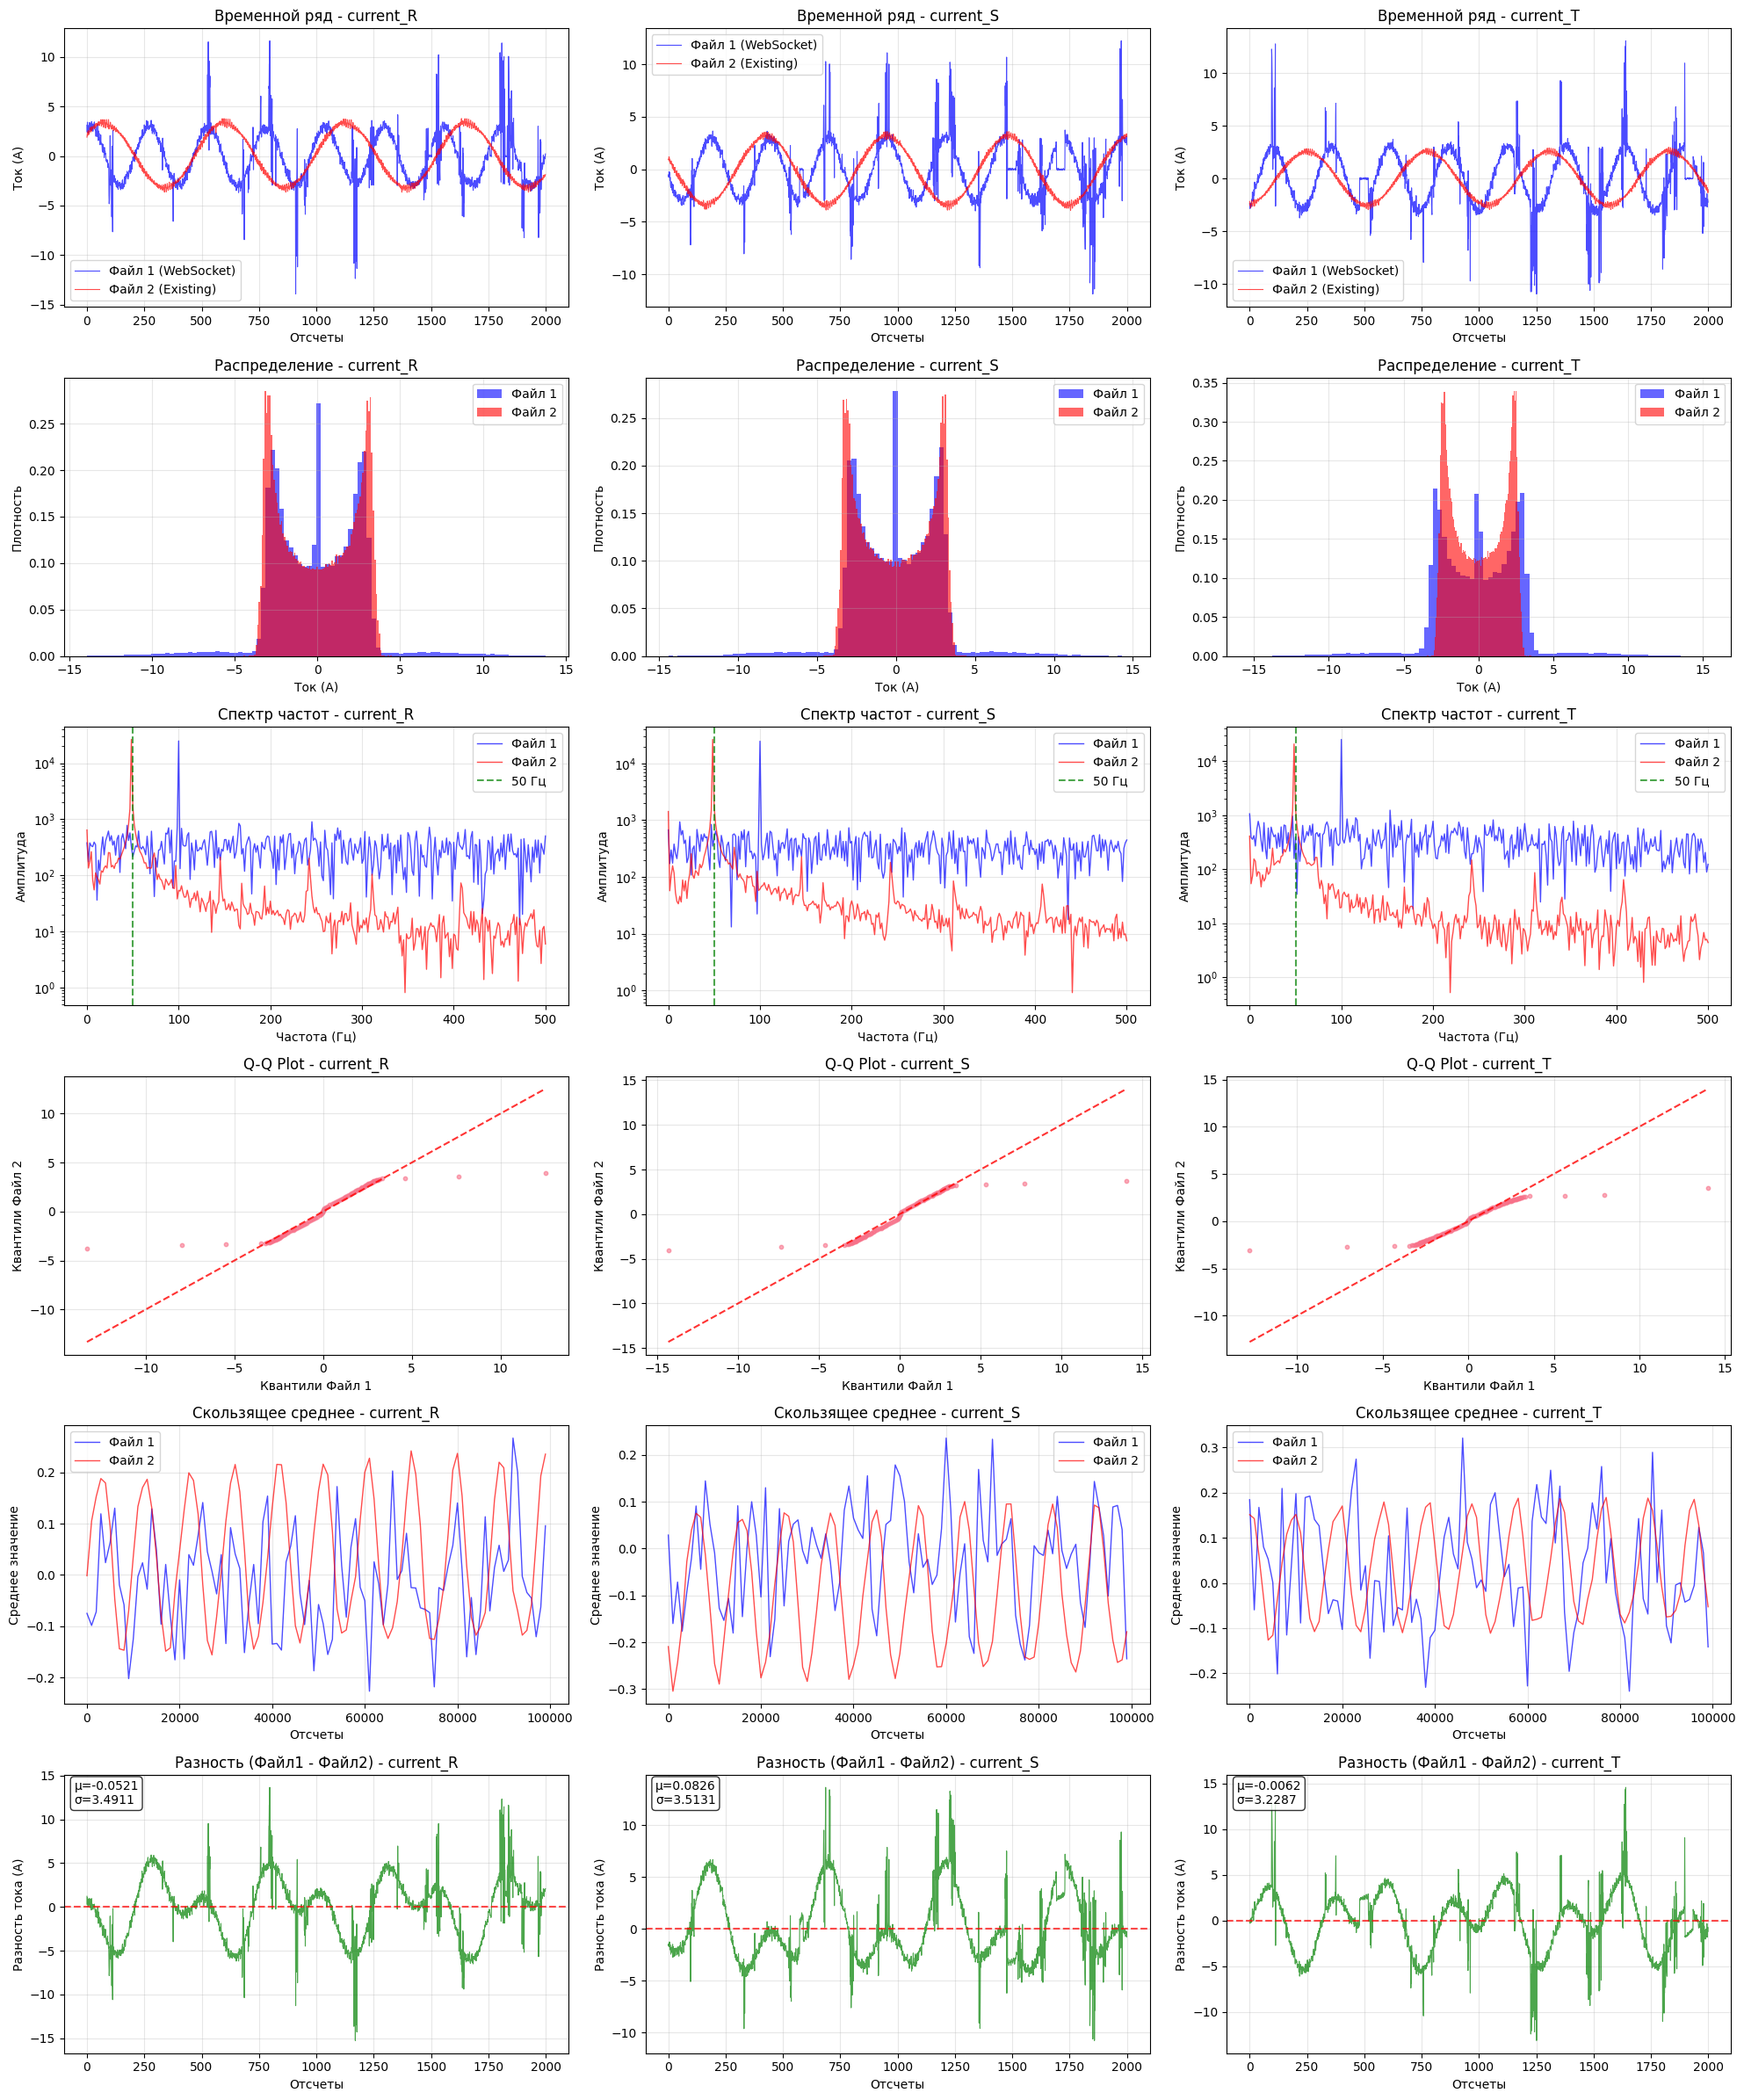

✅ Графики созданы


In [8]:
# Создание детальных графиков сравнения
print("\n📊 СОЗДАНИЕ ГРАФИКОВ СРАВНЕНИЯ")
print("=" * 40)

# Настройка размера графиков
fig = plt.figure(figsize=(20, 24))

# График 1-3: Временные ряды
for i, phase in enumerate(['current_R', 'current_S', 'current_T']):
    ax = plt.subplot(6, 3, i+1)
    
    # Показываем первые 2000 точек для наглядности
    n_points = min(2000, len(df1_sample), len(df2_sample))
    
    plt.plot(df1_sample[phase].iloc[:n_points], 'b-', alpha=0.7, label=f'Файл 1 (WebSocket)', linewidth=0.8)
    plt.plot(df2_sample[phase].iloc[:n_points], 'r-', alpha=0.7, label=f'Файл 2 (Existing)', linewidth=0.8)
    
    plt.title(f'Временной ряд - {phase}')
    plt.xlabel('Отсчеты')
    plt.ylabel('Ток (А)')
    plt.legend()
    plt.grid(True, alpha=0.3)

# График 4-6: Гистограммы распределений
for i, phase in enumerate(['current_R', 'current_S', 'current_T']):
    ax = plt.subplot(6, 3, i+4)
    
    plt.hist(df1_sample[phase], bins=100, alpha=0.6, label='Файл 1', color='blue', density=True)
    plt.hist(df2_sample[phase], bins=100, alpha=0.6, label='Файл 2', color='red', density=True)
    
    plt.title(f'Распределение - {phase}')
    plt.xlabel('Ток (А)')
    plt.ylabel('Плотность')
    plt.legend()
    plt.grid(True, alpha=0.3)

# График 7-9: Спектры частот
for i, phase in enumerate(['current_R', 'current_S', 'current_T']):
    ax = plt.subplot(6, 3, i+7)
    
    freq_data = frequency_analysis[phase]
    freqs = freq_data['freqs']
    fft1 = freq_data['fft1']
    fft2 = freq_data['fft2']
    
    # Показываем до 500 Гц
    mask = freqs <= 500
    plt.semilogy(freqs[mask], fft1[mask], 'b-', alpha=0.7, label='Файл 1', linewidth=1)
    plt.semilogy(freqs[mask], fft2[mask], 'r-', alpha=0.7, label='Файл 2', linewidth=1)
    
    plt.axvline(x=50, color='green', linestyle='--', alpha=0.7, label='50 Гц')
    plt.title(f'Спектр частот - {phase}')
    plt.xlabel('Частота (Гц)')
    plt.ylabel('Амплитуда')
    plt.legend()
    plt.grid(True, alpha=0.3)

# График 10-12: Q-Q plots (сравнение распределений)
for i, phase in enumerate(['current_R', 'current_S', 'current_T']):
    ax = plt.subplot(6, 3, i+10)
    
    # Берем выборки одинакового размера
    n_sample = min(10000, len(df1_sample), len(df2_sample))
    sample1 = np.random.choice(df1_sample[phase], n_sample, replace=False)
    sample2 = np.random.choice(df2_sample[phase], n_sample, replace=False)
    
    # Q-Q plot
    quantiles1 = np.percentile(sample1, np.linspace(0, 100, 100))
    quantiles2 = np.percentile(sample2, np.linspace(0, 100, 100))
    
    plt.scatter(quantiles1, quantiles2, alpha=0.6, s=10)
    
    # Идеальная линия y=x
    min_val = min(quantiles1.min(), quantiles2.min())
    max_val = max(quantiles1.max(), quantiles2.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
    
    plt.title(f'Q-Q Plot - {phase}')
    plt.xlabel('Квантили Файл 1')
    plt.ylabel('Квантили Файл 2')
    plt.grid(True, alpha=0.3)

# График 13-15: Скользящая статистика
for i, phase in enumerate(['current_R', 'current_S', 'current_T']):
    ax = plt.subplot(6, 3, i+13)
    
    # Скользящее среднее и стандартное отклонение
    window_size = 1000
    n_windows = min(len(df1_sample), len(df2_sample)) // window_size
    
    means1 = [np.mean(df1_sample[phase].iloc[j*window_size:(j+1)*window_size]) for j in range(n_windows)]
    means2 = [np.mean(df2_sample[phase].iloc[j*window_size:(j+1)*window_size]) for j in range(n_windows)]
    
    window_indices = np.arange(n_windows) * window_size
    
    plt.plot(window_indices, means1, 'b-', alpha=0.7, label='Файл 1', linewidth=1)
    plt.plot(window_indices, means2, 'r-', alpha=0.7, label='Файл 2', linewidth=1)
    
    plt.title(f'Скользящее среднее - {phase}')
    plt.xlabel('Отсчеты')
    plt.ylabel('Среднее значение')
    plt.legend()
    plt.grid(True, alpha=0.3)

# График 16-18: Разностный анализ
for i, phase in enumerate(['current_R', 'current_S', 'current_T']):
    ax = plt.subplot(6, 3, i+16)
    
    # Берем минимальную длину
    min_len = min(len(df1_sample), len(df2_sample))
    diff = df1_sample[phase].iloc[:min_len].values - df2_sample[phase].iloc[:min_len].values
    
    # Показываем первые 2000 точек разности
    n_points = min(2000, len(diff))
    plt.plot(diff[:n_points], 'g-', alpha=0.7, linewidth=0.8)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    
    plt.title(f'Разность (Файл1 - Файл2) - {phase}')
    plt.xlabel('Отсчеты')
    plt.ylabel('Разность тока (А)')
    plt.grid(True, alpha=0.3)
    
    # Добавляем статистику разности
    plt.text(0.02, 0.98, f'μ={np.mean(diff):.4f}\nσ={np.std(diff):.4f}', 
             transform=ax.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print("✅ Графики созданы")
